In [1]:
import tensorflow as tf

In [2]:
from object_detection.utils import config_util

In [3]:
WORKSPACE_PATH = 'workspace'
SCRIPTS_PATH = 'scripts'
APIMODEL_PATH = 'models'
ANNOTATION_PATH = WORKSPACE_PATH +'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRE_TRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

In [4]:
labels = [{'name':'Damaged', 'id':1}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [5]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: workspace/annotations/train.record
Successfully created the TFRecord file: workspace/annotations/test.record


In [6]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [7]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [8]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [9]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config) 

In [10]:
pipeline_config.model.ssd.num_classes = 1
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRE_TRAINED_MODEL_PATH + '/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type='detection'
pipeline_config.train_input_reader.label_map_path=ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH+'/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH+'/test.record']

In [11]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

In [12]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python models/research/object_detection/model_main_tf2.py --model_dir=workspace/models/my_ssd_mobnet --pipeline_config_path=workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


In [13]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [14]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [15]:
import cv2
import numpy as np

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH + '/label_map.pbtxt')

In [17]:
category_index

{1: {'id': 1, 'name': 'Damaged'}}

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

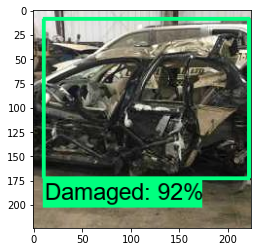

In [20]:
img_path = os.path.join(IMAGE_PATH, 'test', '440.jpeg')
img = cv2.imread(img_path)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1,
            min_score_thresh=0.3,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()